In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
from scipy.integrate import solve_ivp

In [2]:
rho_pp = 900    # Density of pp in kg/m^3
rho_al = 2700   # Density of aluminum in kg/m^3
rho_w = 1000    # Density of water in kg/m^3

c_pp = 1920     # Specific heat of pp in J/kg.K
c_al = 897      # Specific heat of aluminum in J/kg.K
c_w = 4186      # Specific heat of water in J/kg.K

k_pp = 0.28     # Thermal conductivity of pp in W/m.K
k_al = 237      # Thermal conductivity of aluminum in W/m.K

In [3]:
# Geometric properties - tunable parameters
L_pp = 7.6e-5   # Thickness of pp prism in m (0.076mm)
L_al_heating = 0.005  # Thickness of aluminum block during heating in m (5mm)
L_al_cooling = 0.1  # Increased thickness of aluminum block during cooling in m

A_pp = 1.26e-5  # Area of pp prism in m^2 (Marc to provide XY dim)
A_al = A_pp * 8     # Area of aluminum block in m^2 (Marc to provide XY dim)

V_w = 1.5e-8    # Volume of water in m^3 (15uL)

In [4]:
# Thermal capacitance - calculated
C_pp = rho_pp * L_pp * A_pp * c_pp        # Thermal capacitance of pp
C_w = rho_w * V_w * c_w                   # Thermal capacitance of water
C_al_heating = rho_al * L_al_heating * A_al * c_al  # Thermal capacitance of aluminum during heating
C_al_cooling = rho_al * L_al_cooling * A_al * c_al  # Increased thermal capacitance of aluminum during cooling

In [5]:
# Thermal resistance
R_al_pp = L_al_heating / (k_al * A_al)            # Thermal resistance between aluminum and pp
R_pp_w = L_pp / (k_pp * A_pp)             # Thermal resistance between pp and water

P_input = 8.33  # Heater power in watts (value for individual well)

Example 1d RC network. In example (a) we can see resistance and capacitance for each material as well as resistance between materials
<br>
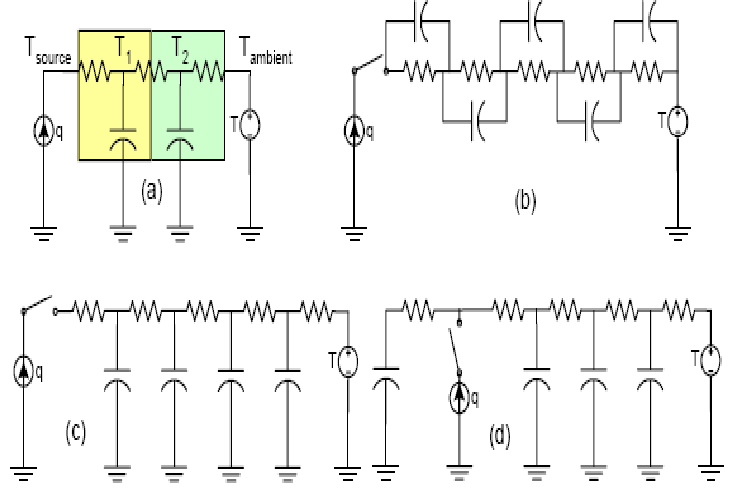

In [15]:
cooling = False

# Apply ODE
def thermal_model(t, T):
    T_al, T_pp, T_w = T
    
    if cooling:
        Q_heater_al = 0
    else:
        Q_heater_al = P_input if T_al < 110 else 0
    
    Q_al_pp = (T_al - T_pp) / R_al_pp

    dT_al_dt = (Q_heater_al - Q_al_pp) / (C_al_heating if not cooling else C_al_cooling)
    dT_pp_dt = (Q_al_pp - (T_pp - T_w) / R_pp_w) / C_pp
    dT_w_dt = (T_pp - T_w) / (R_pp_w * C_w)

    return [dT_al_dt, dT_pp_dt, dT_w_dt]

In [16]:
def event_heat_on(t, T):
    return T[2] - 100
event_heat_on.terminal = True

def event_cool_end(t, T):
    return T[2] - 60
event_cool_end.terminal = True

In [17]:
# single cycle

# Initial conditions ()
T0 = [110, 60, 60]

# Solve for heating phase
sol1 = solve_ivp(thermal_model, [0, 2000], T0, events=event_heat_on, t_eval=np.linspace(0, 2000, 4000))

cooling = True  # Begin cooling process

# Reset temperature for aluminum during cooling phase
T0_cool = [50, sol1.y[1, -1], sol1.y[2, -1]]  # Aluminum starts at 50°C
sol2 = solve_ivp(thermal_model, [sol1.t[-1], 4000], T0_cool, events=event_cool_end, t_eval=np.linspace(sol1.t[-1], 4000, 4000))

# Concatenate time and temperature arrays
t_total = np.concatenate((sol1.t, sol2.t))
T_total = np.column_stack((np.concatenate((sol1.y[0], sol2.y[0])),
                           np.concatenate((sol1.y[1], sol2.y[1])),
                           np.concatenate((sol1.y[2], sol2.y[2])))).T


In [18]:
# multi cycle

# Initialize empty arrays to store results for 40 cycles
t_cycles = np.array([])
T_al_cycles = np.array([])
T_pp_cycles = np.array([])
T_w_cycles = np.array([])

# Initialize the first set of initial conditions
T0 = [100, 60, 60]
cool_al_final_temp = 50  # Initial cooling aluminum plate temperature
t_start = 0

# Loop through 40 cycles
for cycle in range(40):
    cooling = False  # Reset the cooling flag
    sol1 = solve_ivp(thermal_model, [t_start, t_start+2000], T0, events=event_heat_on, t_eval=np.linspace(t_start, t_start+2000, 4000))
    cooling = True  # Begin cooling process
    
    T0_cool = [cool_al_final_temp, sol1.y[1, -1], sol1.y[2, -1]]  # Use the last cooling temperature for aluminum
    sol2 = solve_ivp(thermal_model, [sol1.t[-1], sol1.t[-1]+2000], T0_cool, events=event_cool_end, t_eval=np.linspace(sol1.t[-1], sol1.t[-1]+2000, 4000))

    # Concatenate time and temperature arrays
    t_cycles = np.concatenate((t_cycles, sol1.t, sol2.t))
    T_al_cycles = np.concatenate((T_al_cycles, sol1.y[0], sol2.y[0]))
    T_pp_cycles = np.concatenate((T_pp_cycles, sol1.y[1], sol2.y[1]))
    T_w_cycles = np.concatenate((T_w_cycles, sol1.y[2], sol2.y[2]))

    # Update the initial conditions and the starting time for the next cycle
    T0 = [sol2.y[0, -1], sol2.y[1, -1], sol2.y[2, -1]]
    cool_al_final_temp = sol2.y[0, -1]  # Update the cooling aluminum plate temperature
    t_start = sol2.t[-1]


In [19]:
# single cycle

df = pd.DataFrame({
    'Time (s)': t_total,
    'Aluminum Temperature': T_total[0],
    'Polypropylene Temperature': T_total[1],
    'Water Temperature': T_total[2]
})
# Create an interactive line plot
fig = px.line(df, x='Time (s)', y=['Aluminum Temperature', 'Polypropylene Temperature', 'Water Temperature'],
              labels={'Time (s)': 'Time (s)', 'value': 'Temperature (°C)'},
              title='Temperature Evolution with Power Input and Cooling')

# Add legend, grid, and labels
fig.update_traces(line=dict(width=2))  # Increase line width
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))
fig.update_xaxes(title_text='Time (s)')
fig.update_yaxes(title_text='Temperature (°C)')

# Show the plot
fig.show()

#------------------------------------ Print Results --------------------------------
print(f"Time for water to reach 100°C: {sol1.t[-1]:.2f} seconds")
print(f"Time taken for the aluminum to cool back down to 50°C: {sol2.t[-1]-sol1.t[-1]:.2f} seconds")
print(f"Time for 40 cycles: {((sol1.t[-1] + sol2.t[-1]-sol1.t[-1]) * 40) / 60:.2f} minutes")

Time for water to reach 100°C: 413.60 seconds
Time taken for the aluminum to cool back down to 50°C: 2.50 seconds
Time for 40 cycles: 277.40 minutes


In [20]:
# multi cycle

# Create an interactive line plot for temperature evolution over cycles
fig = go.Figure()

fig.add_trace(go.Scatter(x=t_cycles, y=T_al_cycles, mode='lines', name='Aluminum Temperature'))
fig.add_trace(go.Scatter(x=t_cycles, y=T_pp_cycles, mode='lines', name='Polypropylene Temperature'))
fig.add_trace(go.Scatter(x=t_cycles, y=T_w_cycles, mode='lines', name='Water Temperature'))

fig.update_layout(
    title='Temperature Evolution over 40 Cycles',
    xaxis_title='Time (s)',
    yaxis_title='Temperature (°C)',
    xaxis_showgrid=True,  # This shows the gridlines for the x-axis
    yaxis_showgrid=True,  # This shows the gridlines for the y-axis
    legend=dict(x=0, y=1.1, bgcolor='rgba(255, 255, 255, 0.5)'),
    showlegend=True,
)

# Display the interactive plot
pyo.iplot(fig)


# Print the results
print(f"Time for water to reach 100°C in the last cycle: {sol1.t[-1] - t_start:.2f} seconds")
print(f"Time taken for the aluminum to cool back down to 50°C in the last cycle: {sol2.t[-1] - sol1.t[-1]:.2f} seconds")

# Calculate and print the total time for 40 cycles
total_time = t_cycles[-1] - t_cycles[0]
print(f"Total time for 40 cycles: {total_time/60:.2f} minutes")

Time for water to reach 100°C in the last cycle: -2.50 seconds
Time taken for the aluminum to cool back down to 50°C in the last cycle: 2.50 seconds
Total time for 40 cycles: 6.94 minutes
